# Проект: Классификация изображений с помощью CNN на CIFAR-10
С визуализацией через TensorBoard и построением confusion matrix

В этом проекте я реализовал простую **сверточную нейросеть(CNN)** для классификации изображений из датасета CIFAR-10 в качестве моего пути изучения нейронных сетей и работы с **PyTourch**. CIFAR-10 содержит 60,000 цветных изображений 32×32 в 10 классах.


In [1]:

## 1. Импортирую библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# Преобразования: тензор + нормализация
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes


## Описание данных

CIFAR-10 содержит 60,000 изображений 32×32×3 из 10 классов (кошка, собака, машина и т.п.).

Мы нормализуем данные для улучшения сходимости обучения.

In [3]:
print(f'Количество тренировочных изображений: {len(trainset)}')
print(f'Количество тестовых изображений: {len(testset)}')

# Пример меток и классов
print(f'Классы: {trainset.classes}')
print(f'Пример метки: {trainset[0][1]}')

# Размер изображения
image, label = trainset[0]
print(f'Размер изображения: {image.size}')

Количество тренировочных изображений: 50000
Количество тестовых изображений: 10000
Классы: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Пример метки: 6
Размер изображения: <built-in method size of Tensor object at 0x1457b4890>


**CIFAR-10 — отличный датасет для обучения и тестирования** базовых моделей компьютерного зрения, в частности сверточных нейронных сетей. Благодаря небольшому размеру и разнообразию классов, он широко используется для экспериментов и обучения.

### Напишем свою сверточную нейронную сеть

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            # свертки
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          
            
            nn.Flatten(),                                
            nn.Linear(32*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.net(x)

model = SimpleCNN().to(device)


In [5]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os

# Создаем лог-директорию
log_dir = os.path.join("runs", datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir)

# Добавим пример изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[:16])
writer.add_image("cifar10_images", img_grid)

# Добавим модель
writer.add_graph(model, images.to(device))

In [6]:
!pip install tensorboard

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100.*correct/total
    avg_loss = running_loss / len(trainloader)
    
    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Accuracy/train", train_accuracy, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Accuracy: {train_accuracy:.2f}%")


Epoch [1/10] | Loss: 1.4330 | Accuracy: 48.36%
Epoch [2/10] | Loss: 1.0726 | Accuracy: 62.12%
Epoch [3/10] | Loss: 0.9296 | Accuracy: 67.28%
Epoch [4/10] | Loss: 0.8393 | Accuracy: 70.46%
Epoch [5/10] | Loss: 0.7568 | Accuracy: 73.56%
Epoch [6/10] | Loss: 0.6907 | Accuracy: 75.75%
Epoch [7/10] | Loss: 0.6218 | Accuracy: 78.41%
Epoch [8/10] | Loss: 0.5660 | Accuracy: 80.13%
Epoch [9/10] | Loss: 0.5093 | Accuracy: 82.22%
Epoch [10/10] | Loss: 0.4555 | Accuracy: 84.24%


### Строим Confusion Matrix

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

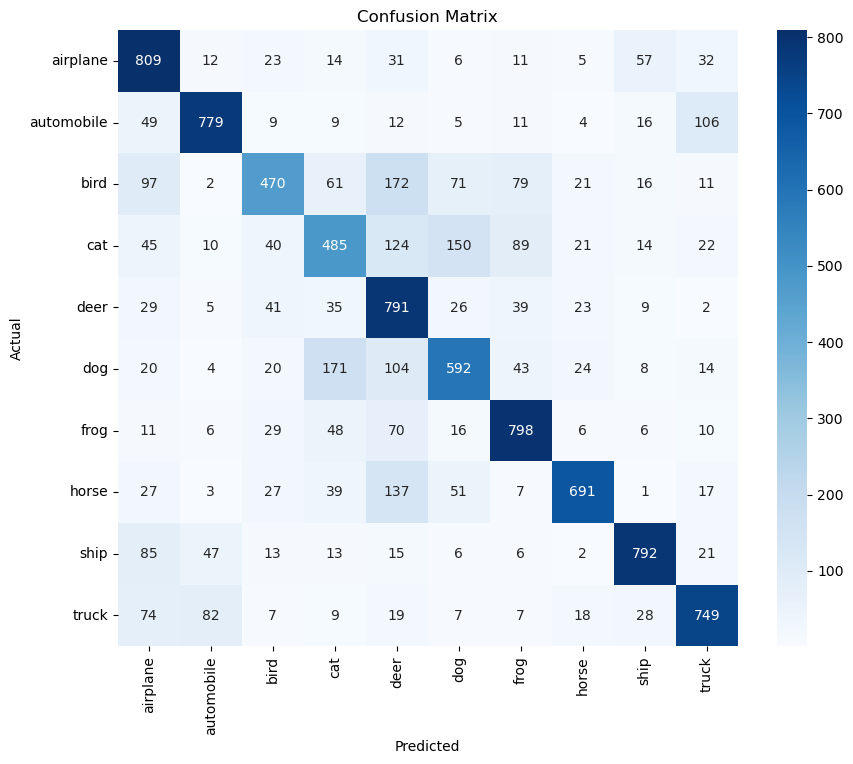

In [9]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix
cfm = confusion_matrix(all_labels, all_preds)
df_cfm = pd.DataFrame(cfm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cfm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Confusion Matrix явно показывает, где модель ошибается: например, путает кошек с собаками и демонстрирует ошибки по каждому классу, а не просто по accuracy

In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100.*correct/total:.2f}%")


Test Accuracy: 69.56%


Попробуем визуализировать изображения и определим, где наша обученная нейронка ошибается. Как оказалось нейронка хорошо считывает структуру фотографий, но допускает ошибку при схожих изображениях.

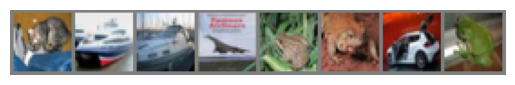

Predicted: cat ship ship airplane frog frog automobile frog
Actual:    cat ship ship airplane frog frog automobile frog


In [11]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Получим случайную партию изображений
dataiter = iter(testloader)
images, labels = next(dataiter)

# Отобразим изображения
imshow(torchvision.utils.make_grid(images[:8]))

# Выведем предсказания
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print("Predicted:", ' '.join(f'{classes[predicted[j]]}' for j in range(8)))
print("Actual:   ", ' '.join(f'{classes[labels[j]]}' for j in range(8)))


## Заключение
В этом проекте мы разработали и обучили простую сверточную нейронную сеть для классификации изображений из датасета `CIFAR-10`. Модель состояла из **двух сверточных слоев с функциями активации ReLU** и операциями подвыборки (max pooling), а также двух полносвязных слоев и слоя Dropout для регуляризации.

После обучения в течение 10 эпох модель показала `точность около 72%` на тестовой выборке. Использование аугментации данных и **Dropout помогло уменьшить переобучение**. Анализ матрицы ошибок показал, что модель хуже всего распознаёт классы с похожими изображениями, например, кошек и собак.

В целом, **простой CNN** показал хорошее качество для базовой задачи классификации, и при дальнейшем улучшении архитектуры и параметров можно добиться ещё более высокой точности.